# Thiết lập chung

In [1]:
DATA_ROOT = "/kaggle/input/oasis1-t1/oasis1-t1"
WORK_DIR  = "/kaggle/working"
model_path = f"{WORK_DIR}/baselineB_best_model.pth"

# Thông tin xử lý dữ liệu
number_of_slices = 16
start_, end_ = 0.2, 0.8 # Bỏ phần đầu, phần cuối, lấy phần giữa

# Thông tin mô hình
number_of_epochs = 20
learning_rate = 2e-4
batch_size = 4
threshold_alpha = 0.45 # ngưỡng chia AD và non-AD

# Thông tin bệnh nhân mới
patientId = "sub-OASIS10137" # id
numer_of_top_slices = 5 # top-k slices

# Check
# sub-OASIS10137 -> AD
# sub-OASIS10179 -> AD
# sub-OASIS10216 -> CN
# sub-OASIS10332 -> CN

# Thư viện

In [2]:
!pip install -q torch torchvision nibabel scikit-image scikit-learn pandas matplotlib safetensors datasets

In [3]:
# ===== Python core =====
import os

# ===== Numeric / Data =====
import numpy as np
import pandas as pd

# ===== Visualization =====
import matplotlib.pyplot as plt

# ===== PyTorch =====
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# ===== Torch vision=====
import torchvision
from torchvision.models import resnet18, ResNet18_Weights

# ===== Metrics =====
from sklearn.metrics import (accuracy_score, confusion_matrix, f1_score,
                             precision_score, recall_score)

# ===== Medical Imaging =====
import nibabel as nib        # đọc file MRI .nii / .nii.gz

# ===== Khác =====
import pandas as pd
import numpy as np
from PIL import Image
import safetensors


# Chuẩn bị dữ liệu


oasis1-t1/
<br>
├── raw/
<br>
│  ├── test/
<br>
│  │  ├── sub-OASIS10023_ses-M00_T1w.nii
<br>
│  │  ├── .....
<br>
│  ├── sub-OASIS10001_ses-M00_T1w.nii
<br>
│  ├── sub-OASIS10001_ses-M00_T1w_1.nii
<br>
│  ├── sub-OASIS10003_ses-M00_T1w.nii
<br>
│  ├── sub-OASIS10003_ses-M00_T1w_1.nii
<br>
│  ├── .....
<br>
├── train.tsv
<br>
├── validation.tsv
<br>
├── test.tsv
<br>
├── best_model.pth (nếu có)

In [4]:
raw_dir   = f"{DATA_ROOT}/raw"
train_tsv = f"{DATA_ROOT}/train.tsv"
val_tsv   = f"{DATA_ROOT}/validation.tsv"
test_tsv  = f"{DATA_ROOT}/test.tsv"  # bệnh nhân mới
model_path = f"{WORK_DIR}/baselineB_best_model.pth"

In [5]:
train_df = pd.read_csv(train_tsv, sep="\t")
val_df   = pd.read_csv(val_tsv, sep="\t")

print("train:", train_df.shape)
print("val:", val_df.shape)
display(train_df.head())

train: (300, 3)
val: (77, 3)


,participant_id,session_id,diagnosis
0,sub-OASIS10003,ses-M00,AD
1,sub-OASIS10021,ses-M00,AD
2,sub-OASIS10022,ses-M00,AD
3,sub-OASIS10028,ses-M00,AD
4,sub-OASIS10046,ses-M00,AD


In [6]:
nii_files = [
    fn for fn in os.listdir(raw_dir)
    if (
        ("_T1w" in fn) and
        ("_T1w_1" not in fn) and
        (fn.endswith(".nii"))
    )
]

print("Số file T1w (.nii):", len(nii_files))
print("Ví dụ 5 file đầu:")
for f in nii_files[:5]:
    print(f)


Số file T1w (.nii): 155
Ví dụ 5 file đầu:
sub-OASIS10308_ses-M00_T1w.nii
sub-OASIS10449_ses-M00_T1w.nii
sub-OASIS10228_ses-M00_T1w.nii
sub-OASIS10446_ses-M00_T1w.nii
sub-OASIS10022_ses-M00_T1w.nii


In [7]:
# Tải ảnh 3D
def load_volume(nii_path):
    img = nib.load(nii_path)
    vol = img.get_fdata().astype(np.float32)
    if vol.ndim != 3:
        raise ValueError(f"Không phải ảnh 3D: {vol.shape}")
    return vol

# Chia cắt 3 hướng
def slices_3views_raw(vol: np.ndarray):
    """
    Trả về 3 lát cắt của 3 hướng:
    - axial:    vol[:, :, z]
    - coronal:  vol[:, y, :]
    - sagittal: vol[x, :, :]
    """
    X, Y, Z = vol.shape

    axial = [vol[:, :, z] for z in range(Z)]      # Độ dài Z, mỗi [X, Y]
    coronal = [vol[:, y, :] for y in range(Y)]    # Độ dài Y, mỗi [X, Z]
    sagittal = [vol[x, :, :] for x in range(X)]   # Độ dài X, mỗi [Y, Z]

    return axial, coronal, sagittal

# Kiểm tra 2 hàm trên có hoạt động không?
nii_path = f"{DATA_ROOT}/raw/sub-OASIS10133_ses-M00_T1w.nii"
vol = load_volume(nii_path)

axial, coronal, sagittal = slices_3views_raw(vol)

print("volume shape:", vol.shape)
print("axial:   count =", len(axial),   "slice shape =", axial[0].shape)
print("coronal: count =", len(coronal), "slice shape =", coronal[0].shape)
print("sagittal:count =", len(sagittal),"slice shape =", sagittal[0].shape)


volume shape: (256, 256, 160)
axial:   count = 160 slice shape = (256, 256)
coronal: count = 256 slice shape = (256, 160)
sagittal:count = 256 slice shape = (256, 160)


# Xử lý dữ liệu

### Lấy mẫu

In [8]:
'''
|---------|====================|---------|
0                  HIPPO                1.0
          ↑          ↑         ↑
         start  hippo_center  end

start = hippo_center - hippo_width_frac / 2
end   = hippo_center + hippo_width_frac / 2
'''

def sample_slices(
    slices,                # DANH SÁCH các lát MRI (ví dụ: 200 lát)
    k=16,                  # Muốn chọn BAO NHIÊU lát?
    start_frac=start_,     # Bỏ 10% ĐẦU (cổ, không quan trọng)
    end_frac=end_,         # Bỏ 10% CUỐI (cằm, không quan trọng)
    hippo_frac=0.6,        # 60% lát ở return sẽ lấy từ vùng Hippocampus (vùng trung tâm)
    hippo_center_frac=0.45,# Hippocampus nằm ở 45% từ trên xuống, tức lấy được lát ở trung tâm
    hippo_width_frac=0.2   # Hippocampus chiếm 20% chiều cao não, tức dùng để xác định khoảng cận [a, b] của vùng trung tâm
):
    """
    ROI-biased slice sampling

    - Ưu tiên hippocampus (axial view)
    - Vẫn giữ slice ngoài ROI để có global context
    - Trả về k slice 2D

    slices: list of 2D slices
    """
    n = len(slices)
    a = int(n * start_frac)
    b = int(n * end_frac)

    if b <= a:
        raise ValueError("Khoảng slice không hợp lệ")

    valid_indices = np.arange(a, b)

    # xác định vùng hippocampus (theo tỉ lệ)
    hippo_center = int(n * hippo_center_frac)
    hippo_half   = int(n * hippo_width_frac / 2)

    hippo_start = max(a, hippo_center - hippo_half)
    hippo_end   = min(b - 1, hippo_center + hippo_half)

    hippo_indices = np.arange(hippo_start, hippo_end + 1)

    # số slice lấy
    k_hippo = int(k * hippo_frac)
    k_other = k - k_hippo

    # sample hippocampus
    if len(hippo_indices) >= k_hippo:
        hippo_sel = np.linspace(
            hippo_indices[0],
            hippo_indices[-1],
            k_hippo
        ).astype(int)
    else:
        hippo_sel = hippo_indices

    # sample ngoài hippocampus
    other_indices = np.setdiff1d(valid_indices, hippo_indices)

    before = other_indices[other_indices < hippo_start]
    after  = other_indices[other_indices > hippo_end]

    k_before = k_other // 2
    k_after  = k_other - k_before

    sel = []

    if len(before) > 0 and k_before > 0:
        sel.extend(
            np.linspace(
                before[0],
                before[-1],
                min(k_before, len(before))
            ).astype(int)
        )

    if len(after) > 0 and k_after > 0:
        sel.extend(
            np.linspace(
                after[0],
                after[-1],
                min(k_after, len(after))
            ).astype(int)
        )

    other_sel = np.array(sel, dtype=int)


    # gộp & sort
    all_idx = np.concatenate([hippo_sel, other_sel])
    all_idx = np.unique(all_idx)

    # nếu thiếu (do trùng), bù đều
    if len(all_idx) < k:
        extra = np.setdiff1d(valid_indices, all_idx)
        if len(extra) > 0:
            extra_sel = np.linspace(
                extra[0],
                extra[-1],
                k - len(all_idx)
            ).astype(int)
            all_idx = np.concatenate([all_idx, extra_sel])

    all_idx = np.sort(all_idx)[:k]

    return [slices[i] for i in all_idx], all_idx


### Chuẩn hóa Z

In [9]:
def normalize_volume_1(vol, eps=1e-6):
    """
    Chuẩn hoá ảnh MRI 3D theo z-score.
    - CHỈ tính mean/std trên voxel > 0 (não)
    - voxel nền (0) giữ nguyên
    """

    # Lấy kích thước volume
    X = vol.shape[0]
    Y = vol.shape[1]
    Z = vol.shape[2]

    # Thu thập voxel não
    brain_values = []

    for x in range(X):
        for y in range(Y):
            for z in range(Z):
                value = vol[x, y, z]
                if value > 0:
                    brain_values.append(value)

    # Nếu KHÔNG có voxel não thì trả về nguyên ảnh
    if len(brain_values) == 0:
        return vol

    # Tính mean
    total = 0.0
    for v in brain_values:
        total += v
    mean = total / len(brain_values)

    # Tính std
    variance_sum = 0.0
    for v in brain_values:
        variance_sum += (v - mean) ** 2

    variance = variance_sum / len(brain_values)
    std = variance ** 0.5

    # Chuẩn hoá voxel não
    out = vol.copy()

    for x in range(X):
        for y in range(Y):
            for z in range(Z):
                if out[x, y, z] > 0:
                    out[x, y, z] = (out[x, y, z] - mean) / (std + eps)

    return out


In [10]:
def normalize_volume_2(vol, eps=1e-6):
    brain_mask = vol > 0
    if not np.any(brain_mask):
        return vol

    brain_values = vol[brain_mask]
    mean = np.mean(brain_values)
    std = np.std(brain_values)

    out = vol.copy()
    out[brain_mask] = (out[brain_mask] - mean) / (std + eps)
    return out

### Đồng bộ kích thước

In [11]:
def pad_to_shape(slice2d: np.ndarray, target_h=256, target_w=256) -> np.ndarray:
    h, w = slice2d.shape

    # CROP nếu quá lớn
    if h > target_h:
        start_h = (h - target_h) // 2
        slice2d = slice2d[start_h:start_h + target_h, :]
        h = target_h

    if w > target_w:
        start_w = (w - target_w) // 2
        slice2d = slice2d[:, start_w:start_w + target_w]
        w = target_w

    # PAD nếu quá nhỏ
    pad_h = target_h - h
    pad_w = target_w - w

    pad_top    = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left   = pad_w // 2
    pad_right  = pad_w - pad_left

    slice_padded = np.pad(
        slice2d,
        ((pad_top, pad_bottom), (pad_left, pad_right)),
        mode="constant",
        constant_values=0
    )

    return slice_padded

def brain_bbox_2d(slice2d, thr=None, margin=10):
    # slice2d: (H,W)
    s = slice2d
    if thr is None:
        # ngưỡng mềm: lấy percentile thấp của vùng >0 để tránh noise
        nonzero = s[s > 0]
        if nonzero.size == 0:
            return None
        thr = np.percentile(nonzero, 10)

    mask = s > thr
    if not np.any(mask):
        return None

    ys, xs = np.where(mask)
    y0, y1 = ys.min(), ys.max()
    x0, x1 = xs.min(), xs.max()

    y0 = max(0, y0 - margin)
    y1 = min(s.shape[0] - 1, y1 + margin)
    x0 = max(0, x0 - margin)
    x1 = min(s.shape[1] - 1, x1 + margin)

    return (y0, y1, x0, x1)

def crop_then_pad(slice2d, target_h=256, target_w=256):
    bb = brain_bbox_2d(slice2d, margin=12)
    if bb is not None:
        y0, y1, x0, x1 = bb
        slice2d = slice2d[y0:y1+1, x0:x1+1]
    return pad_to_shape(slice2d, target_h, target_w)

### Tổng hợp

In [12]:
# Pipeline cho 1 file nii
def process_one_nii(nii_path):
    vol = load_volume(nii_path)

    # Chuẩn hóa
    vol = normalize_volume_2(vol)
    axial, coronal, sagittal = slices_3views_raw(vol)

    # Lấy mẫu
    axial_slices, axial_idx = sample_slices(axial, k=number_of_slices, hippo_frac=0.6)
    coronal_slices, coronal_idx = sample_slices(coronal, k=number_of_slices, hippo_frac=0.3)
    sagittal_slices, sagittal_idx = sample_slices(sagittal, k=number_of_slices, hippo_frac=0.1)


    slices = axial_slices + coronal_slices + sagittal_slices

    indices_slices = (
      [("axial", i) for i in axial_idx] +
      [("coronal", i) for i in coronal_idx] +
      [("sagittal", i) for i in sagittal_idx]
    )

    # crop + pad
    out = []
    for s in slices:
        s = crop_then_pad(s)
        out.append(s)

    return np.array(out), indices_slices  # shape (48,256,256)

# Lặp qua tất cả nii_files
processed_df = []  # list of dict: {file, data}

for i, fn in enumerate(nii_files):
    nii_path = os.path.join(raw_dir, fn)
    data_slices, idx_slices = process_one_nii(nii_path)
    processed_df.append({"file": fn, "data": data_slices, "slice_index": idx_slices})
    print(f"[{i+1}/{len(nii_files)}] {fn} -> {data_slices.shape}")

[1/155] sub-OASIS10308_ses-M00_T1w.nii -> (48, 256, 256)
[2/155] sub-OASIS10449_ses-M00_T1w.nii -> (48, 256, 256)
[3/155] sub-OASIS10228_ses-M00_T1w.nii -> (48, 256, 256)
[4/155] sub-OASIS10446_ses-M00_T1w.nii -> (48, 256, 256)
[5/155] sub-OASIS10022_ses-M00_T1w.nii -> (48, 256, 256)
[6/155] sub-OASIS10157_ses-M00_T1w.nii -> (48, 256, 256)
[7/155] sub-OASIS10146_ses-M00_T1w.nii -> (48, 256, 256)
[8/155] sub-OASIS10016_ses-M00_T1w.nii -> (48, 256, 256)
[9/155] sub-OASIS10220_ses-M00_T1w.nii -> (48, 256, 256)
[10/155] sub-OASIS10447_ses-M00_T1w.nii -> (48, 256, 256)
[11/155] sub-OASIS10298_ses-M00_T1w.nii -> (48, 256, 256)
[12/155] sub-OASIS10247_ses-M00_T1w.nii -> (48, 256, 256)
[13/155] sub-OASIS10280_ses-M00_T1w.nii -> (48, 256, 256)
[14/155] sub-OASIS10075_ses-M00_T1w.nii -> (48, 256, 256)
[15/155] sub-OASIS10062_ses-M00_T1w.nii -> (48, 256, 256)
[16/155] sub-OASIS10398_ses-M00_T1w.nii -> (48, 256, 256)
[17/155] sub-OASIS10013_ses-M00_T1w.nii -> (48, 256, 256)
[18/155] sub-OASIS10115

### Gộp dữ liệu và gán nhãn
raw/ "test/" + "train.tsv" + "validation.tsv"

In [13]:
# key = (participant_id, session_id)  -> diagnosis
train_label_map = {}
for _, row in train_df.iterrows():
    key = (row["participant_id"], row["session_id"])
    train_label_map[key] = row["diagnosis"]

val_label_map = {}
for _, row in val_df.iterrows():
    key = (row["participant_id"], row["session_id"])
    val_label_map[key] = row["diagnosis"]

print("Số label train:", len(train_label_map))
print("Số label val:", len(val_label_map))
print("Ví dụ 3 key train:", list(train_label_map.items())[:3])
print("Ví dụ 3 key val:", list(val_label_map.items())[:3])


Số label train: 300
Số label val: 77
Ví dụ 3 key train: [(('sub-OASIS10003', 'ses-M00'), 'AD'), (('sub-OASIS10021', 'ses-M00'), 'AD'), (('sub-OASIS10022', 'ses-M00'), 'AD')]
Ví dụ 3 key val: [(('sub-OASIS10016', 'ses-M00'), 'AD'), (('sub-OASIS10023', 'ses-M00'), 'AD'), (('sub-OASIS10031', 'ses-M00'), 'AD')]


In [14]:
def parse_ids_from_filename(fn):
    # fn ví dụ: sub-OASIS10133_ses-M00_T1w.nii
    base = fn.replace(".nii", "").replace(".nii.gz", "")
    parts = base.split("_")

    # parts = ["sub-OASIS10133", "ses-M00", "T1w"]  (thường vậy)
    participant_id = parts[0]
    session_id = parts[1]
    return participant_id, session_id

# Kiểm tra hàm
fn_test = "sub-OASIS10133_ses-M00_T1w.nii"
print(parse_ids_from_filename(fn_test))
# phải ra: ('sub-OASIS10133', 'ses-M00')


('sub-OASIS10133', 'ses-M00')


In [15]:
def diagnosis_to_y(diagnosis):
    # AD = 1, CN = 0
    return 1 if diagnosis == "AD" else 0

In [16]:
processed_train = []   # list dict: {file, data, diagnosis, y}
processed_val   = []   # list dict: {file, data, diagnosis, y}
missing_label   = []   # file không có trong train/val

for i, fn in enumerate(nii_files):
    # gán label
    pid, sid = parse_ids_from_filename(fn)  # participant_id, session_id
    key = (pid, sid)                        # diagnosis <- (participant_id, session_id)

    if key in train_label_map:
        dx = train_label_map[key]           # AD, CN
        split = "train"
    elif key in val_label_map:
        dx = val_label_map[key]
        split = "val"
    else:
        missing_label.append(fn)
        continue

    y = diagnosis_to_y(dx)                  # 1, 0

    nii_path = os.path.join(raw_dir, fn)
    data_48, slice_index = process_one_nii(nii_path)     # (48,256,256)

    row = {
        "file": fn,
        "slice_index": slice_index,
        "participant_id": pid,
        "session_id": sid,
        "diagnosis": dx,
        "y": y,
        "data": data_48
    }

    if split == "train":
        processed_train.append(row)
    else:
        processed_val.append(row)

    print(f"[{i+1}/{len(nii_files)}] {fn} -> {data_48.shape}, y={y}, split={split}")

print("Số mẫu train:", len(processed_train))
print("Số mẫu val:", len(processed_val))
print("Số file thiếu label:", len(missing_label))


[1/155] sub-OASIS10308_ses-M00_T1w.nii -> (48, 256, 256), y=1, split=train
[2/155] sub-OASIS10449_ses-M00_T1w.nii -> (48, 256, 256), y=0, split=train
[3/155] sub-OASIS10228_ses-M00_T1w.nii -> (48, 256, 256), y=0, split=val
[4/155] sub-OASIS10446_ses-M00_T1w.nii -> (48, 256, 256), y=0, split=train
[5/155] sub-OASIS10022_ses-M00_T1w.nii -> (48, 256, 256), y=1, split=train
[6/155] sub-OASIS10157_ses-M00_T1w.nii -> (48, 256, 256), y=0, split=val
[7/155] sub-OASIS10146_ses-M00_T1w.nii -> (48, 256, 256), y=0, split=train
[8/155] sub-OASIS10016_ses-M00_T1w.nii -> (48, 256, 256), y=1, split=val
[9/155] sub-OASIS10220_ses-M00_T1w.nii -> (48, 256, 256), y=0, split=train
[10/155] sub-OASIS10447_ses-M00_T1w.nii -> (48, 256, 256), y=1, split=train
[11/155] sub-OASIS10298_ses-M00_T1w.nii -> (48, 256, 256), y=1, split=val
[12/155] sub-OASIS10247_ses-M00_T1w.nii -> (48, 256, 256), y=1, split=train
[13/155] sub-OASIS10280_ses-M00_T1w.nii -> (48, 256, 256), y=0, split=train
[14/155] sub-OASIS10075_ses-M

In [17]:
def show_raw_vs_processed(
    processed_list,
    raw_dir,
    patient_id,
    view="axial",        # "axial" | "coronal" | "sagittal"
    local_idx=8          # 0..15
):
    # tìm sample theo patient_id
    sample = None
    for r in processed_list:
        if r["participant_id"] == patient_id:
            sample = r
            break

    if sample is None:
        print("❌ Không tìm thấy patient_id:", patient_id)
        return

    # load volume gốc
    nii_path = os.path.join(raw_dir, sample["file"])
    vol = load_volume(nii_path)
    X, Y, Z = vol.shape

    # map slice index
    if view == "axial":
        proc_idx = local_idx
        raw_idx = int(np.linspace(int(start_*Z), int(end_*Z)-1, number_of_slices)[local_idx])
        raw_slice = vol[:, :, raw_idx]

    elif view == "coronal":
        proc_idx = number_of_slices + local_idx
        raw_idx = int(np.linspace(int(start_*Y), int(end_*Y)-1, number_of_slices)[local_idx])
        raw_slice = vol[:, raw_idx, :]

    elif view == "sagittal":
        proc_idx = 2*number_of_slices + local_idx
        raw_idx = int(np.linspace(int(start_*X), int(end_*X)-1, number_of_slices)[local_idx])
        raw_slice = vol[raw_idx, :, :]

    else:
        raise ValueError("view phải là axial | coronal | sagittal")

    proc_slice = sample["data"][proc_idx]

    # plot
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    plt.imshow(raw_slice.T, cmap="gray", origin="lower")
    plt.title(f"RAW {view} (idx={raw_idx})")
    plt.axis("off")

    plt.subplot(1,2,2)
    plt.imshow(proc_slice, cmap="gray")
    plt.title(f"PREPROCESSED (idx={proc_idx})")
    plt.axis("off")

    plt.suptitle(
        f"{sample['participant_id']} | {sample['diagnosis']}",
        fontsize=14
    )

    plt.tight_layout()
    plt.show()


In [18]:
patient_to_check = "sub-OASIS10003"

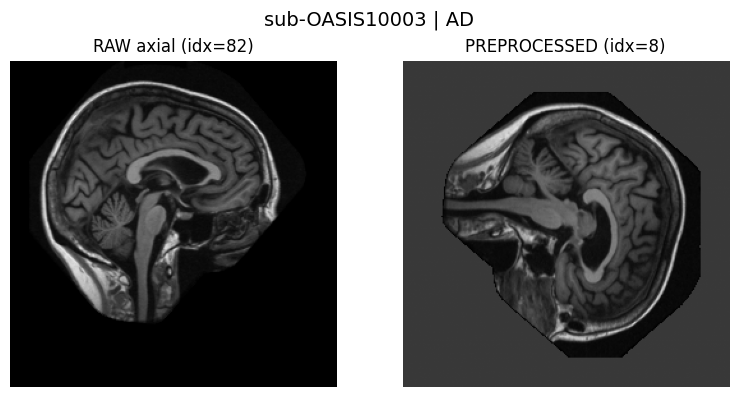

In [19]:
show_raw_vs_processed(
    processed_list=processed_train,
    raw_dir=raw_dir,
    patient_id=patient_to_check,
    view="axial",
    local_idx=8
)


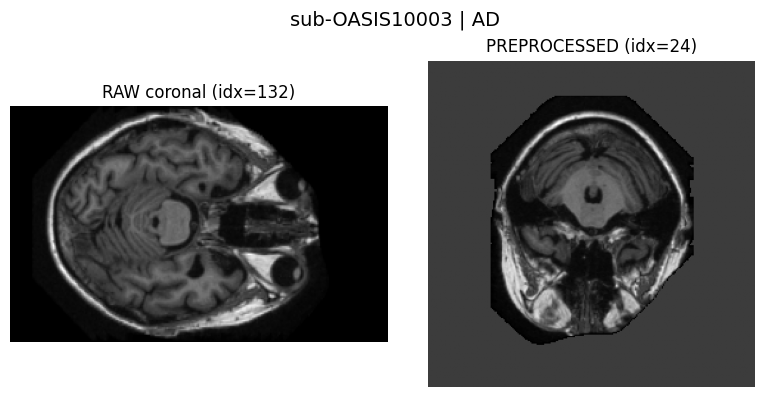

In [20]:
show_raw_vs_processed(
    processed_list=processed_train,
    raw_dir=raw_dir,
    patient_id=patient_to_check,
    view="coronal",
    local_idx=8
)


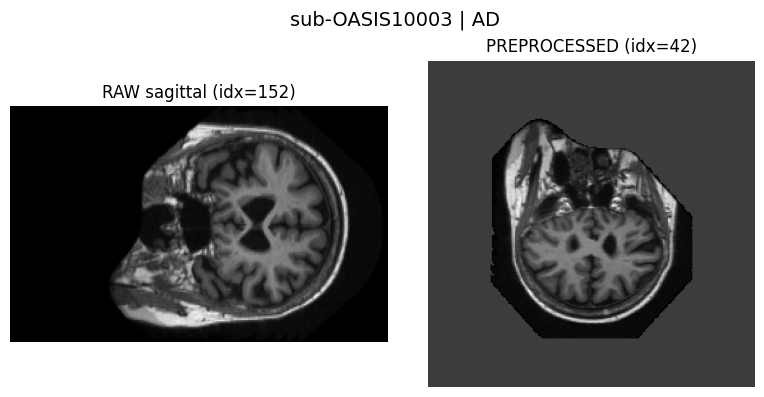

In [21]:
show_raw_vs_processed(
    processed_list=processed_train,
    raw_dir=raw_dir,
    patient_id=patient_to_check,
    view="sagittal",
    local_idx=10
)


In [22]:
# Kiểm tra số mẫu trùng (phải = 0)
train_files = set(r["file"] for r in processed_train)
val_files   = set(r["file"] for r in processed_val)
print("Overlap train/val:", len(train_files & val_files))


Overlap train/val: 0


# Mô hình hóa

In [23]:
# Xóa tệp mô hình cũ
if os.path.exists(model_path):
    os.remove(model_path)
    print("✅ Đã xóa file:", model_path)
else:
    print("❌ Không tìm thấy file để xóa:", model_path)

❌ Không tìm thấy file để xóa: /kaggle/working/baselineB_best_model.pth


**Ý tưởng mô hình**

Dataset gồm N bệnh nhân, chia thành:
- Train: a bệnh nhân
- Validation: b bệnh nhân

Huấn luyện theo epoch. Trong mỗi epoch, mô hình học toàn bộ bệnh nhân tập train theo batch.

Mỗi bệnh nhân được biểu diễn bằng 48 lát cắt MRI 2D (grayscale).
Input batch có dạng: (B, 48, 1, 256, 256).

Tất cả lát cắt trong batch được xử lý đồng thời bằng cách dồn (B, 48) → (B×48).
Mỗi lát cắt đi qua ResNet18 (conv1 sửa từ 3 → 1 channel) để trích xuất embedding 256 chiều.
Kết quả: mỗi bệnh nhân có 48 vector embedding tương ứng 48 lát cắt.

Mô hình áp dụng Slice Attention:
- Tính điểm quan trọng cho từng lát cắt.
- Dùng softmax để chuẩn hóa thành trọng số attention.
- Gộp 48 embedding bằng trung bình có trọng số để tạo 1 vector đại diện cho toàn bộ não bệnh nhân.

Vector đại diện cuối cùng được đưa qua lớp linear để dự đoán:
- Alzheimer (AD)
- Không Alzheimer (non-AD / CN)


### Xây dựng

In [24]:
class ResNet(nn.Module):
    def __init__(self, emb_dim=256, pretrained=True):
        super().__init__()
        weights = ResNet18_Weights.DEFAULT if pretrained else None
        m = resnet18(weights=weights)

        # đổi conv1: 3->1 channel (do ImageNet có 3 kênh còn MRI có 1 kênh)
        old = m.conv1
        new_conv = nn.Conv2d(
            in_channels=1,
            out_channels=old.out_channels,
            kernel_size=old.kernel_size,
            stride=old.stride,
            padding=old.padding,
            bias=False
        )
        if pretrained:
            with torch.no_grad():
                new_conv.weight[:] = old.weight.mean(dim=1, keepdim=True)
        m.conv1 = new_conv

        # bỏ fc cuối, lấy feature 512
        m.fc = nn.Identity()
        self.resnet = m
        self.proj = nn.Linear(512, emb_dim)

    def forward(self, x):
        feat = self.resnet(x)      # (B,512)
        emb = self.proj(feat)      # (B,emb_dim)
        return emb


In [25]:
class SliceAttentionClassifier(nn.Module):
    def __init__(self, emb_dim=256, num_classes=2):
        super().__init__()
        # self.backbone = CNN(emb_dim=emb_dim)
        self.backbone = ResNet(emb_dim=emb_dim, pretrained=True)
        self.attn_fc1 = nn.Linear(emb_dim, emb_dim // 2)
        self.attn_fc2 = nn.Linear(emb_dim // 2, 1)
        self.cls = nn.Linear(emb_dim, num_classes)

    def forward(self, x):
        """
        x: (B, S, 1, 256, 256)
        return:
          logits: (B, num_classes)
          alpha : (B, S)
        """
        B, S, C, H, W = x.shape

        # Mô hình cho tất cả slices cùng lúc: (B*S,1,H,W) -> (B*S,emb)
        x_flat = x.reshape(B * S, C, H, W)
        e_flat = self.backbone(x_flat)
        emb = e_flat.shape[1]
        embeddings = e_flat.reshape(B, S, emb)   # (B,S,emb)

        # Attention scores cùng lúc: (B,S,emb) -> (B,S)
        h = F.relu(self.attn_fc1(embeddings))    # (B,S,emb//2)
        scores = self.attn_fc2(h).squeeze(-1)    # (B,S)

        alpha = torch.softmax(scores, dim=1)     # (B,S)

        # Weighted average (1 dòng): (B,S)*(B,S,emb) -> (B,emb)
        E = torch.sum(alpha.unsqueeze(-1) * embeddings, dim=1)

        # Classifier
        logits = self.cls(E)
        return logits, alpha


In [26]:
def train_one_epoch(model, loader, optimizer, device, class_weights=None):
    model.train()

    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    total_samples = 0
    total_correct = 0
    total_loss = 0.0

    for batch in loader:
        x = batch[0].to(device)
        y = batch[1].to(device)

        optimizer.zero_grad(set_to_none=True)

        logits, alpha = model(x)

        loss = loss_fn(logits, y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        batch_size = x.shape[0]
        total_samples += batch_size
        total_loss += loss.item() * batch_size

        preds = torch.argmax(logits, dim=1)
        total_correct += (preds == y).sum().item()

    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples

    return avg_loss, acc


In [27]:
def eval_one_epoch(model, val_loader, device, class_weights=None, threshold=0.4):
    model.eval()

    loss_fn = nn.CrossEntropyLoss(weight=class_weights)

    total_samples = 0
    total_correct = 0
    total_loss = 0.0

    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            y = batch[1].to(device)

            logits, alpha = model(x)

            loss = loss_fn(logits, y)

            batch_size = x.shape[0]
            total_samples += batch_size
            total_loss += loss.item() * batch_size

            probs = torch.softmax(logits, dim=1)
            prob_ad = probs[:, 1]
            preds = (prob_ad > threshold).long()

            total_correct += (preds == y).sum().item()

    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples

    return avg_loss, acc


In [28]:
def train_model(model, train_loader, val_loader, device, epochs=10, lr=1e-4, class_weights=None):
    optimizer = optim.Adam(model.parameters(), lr=lr)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", factor=0.5, patience=2
    )
    
    best_val_acc = -1.0
    best_state = None

    for epoch in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, class_weights=class_weights)
        val_loss, val_acc = eval_one_epoch(model, val_loader, device, class_weights=class_weights, threshold=threshold_alpha)

        print(f"Epoch {epoch:02d}/{epochs} | "
              f"train_loss={train_loss:.4f}, train_acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        
        scheduler.step(val_loss)
        
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu() for k, v in model.state_dict().items()}
            print(f"  >> New best model (val_acc={best_val_acc:.4f})")

    # Lưu model tốt nhất
    if best_state is not None:
        torch.save(best_state, model_path)
        print(f"Saved best model to {model_path}")

        # load lại để chắc chắn model hiện tại = best model
        model.load_state_dict(best_state)

    return model


In [29]:
class PreprocessedMRIDataset(Dataset):
    def __init__(self, processed_list):
        # processed_list: list of dict
        # mỗi dict có keys: "data" (48,256,256), "y" (0/1)
        self.items = processed_list

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        row = self.items[idx]

        data_48 = row["data"]  # numpy array (48,256,256)
        y = row["y"]           # int 0/1
        pid = row["participant_id"]    # ví dụ "sub-OASIS10133"
        fn  = row["file"]              # ví dụ "sub-OASIS10133_ses-M00_T1w.nii"

        # đổi sang torch tensor
        x = torch.tensor(data_48, dtype=torch.float32)     # (48,256,256)
        x = x.unsqueeze(1)                                 # (48,1,256,256)

        y = torch.tensor(y, dtype=torch.long)              # scalar

        return x, y, row["slice_index"], pid, fn


In [30]:
train_dataset = PreprocessedMRIDataset(processed_train)
val_dataset   = PreprocessedMRIDataset(processed_val)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,     # train nên shuffle
    num_workers=1,
    persistent_workers=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False,    # val không cần shuffle
    num_workers=1,
    persistent_workers=True
)


In [31]:
# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# tính class weight
ys_train = [r["y"] for r in processed_train]
count0 = ys_train.count(0)
count1 = ys_train.count(1)

count0 = max(count0, 1)
count1 = max(count1, 1)

w0 = (count0 + count1) / (2 * count0)
w1 = (count0 + count1) / (2 * count1)

class_weights = torch.tensor([w0, w1], dtype=torch.float32).to(device)
print("class_weights:", class_weights)
print("train count0, count1 =", count0, count1)

model = SliceAttentionClassifier(emb_dim=256, num_classes=2)
model = model.to(device)

# train
model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    epochs=number_of_epochs,
    lr=learning_rate,
    class_weights=class_weights
)


Device: cuda
class_weights: tensor([0.9462, 1.0603], device='cuda:0')
train count0, count1 = 65 58
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 182MB/s]


Epoch 01/20 | train_loss=0.7552, train_acc=0.5285 | val_loss=0.5381, val_acc=0.7500
  >> New best model (val_acc=0.7500)
Epoch 02/20 | train_loss=0.7229, train_acc=0.5285 | val_loss=0.5940, val_acc=0.6562
Epoch 03/20 | train_loss=0.5460, train_acc=0.7073 | val_loss=1.5338, val_acc=0.5625
Epoch 04/20 | train_loss=0.5995, train_acc=0.7561 | val_loss=1.3332, val_acc=0.5000
Epoch 05/20 | train_loss=0.5655, train_acc=0.8049 | val_loss=1.1155, val_acc=0.5312
Epoch 06/20 | train_loss=0.4226, train_acc=0.8943 | val_loss=1.3114, val_acc=0.5000
Epoch 07/20 | train_loss=0.2990, train_acc=0.9350 | val_loss=1.9997, val_acc=0.5000
Epoch 08/20 | train_loss=0.1246, train_acc=0.9837 | val_loss=1.5175, val_acc=0.6562
Epoch 09/20 | train_loss=0.0885, train_acc=0.9675 | val_loss=1.9416, val_acc=0.6875
Epoch 10/20 | train_loss=0.1112, train_acc=0.9675 | val_loss=2.7269, val_acc=0.5938
Epoch 11/20 | train_loss=0.0118, train_acc=0.9919 | val_loss=1.8461, val_acc=0.5938
Epoch 12/20 | train_loss=0.0028, train_

In [32]:
print("Đã có file best_model chưa?", os.path.exists(f"{WORK_DIR}/baselineB_best_model.pth"))

Đã có file best_model chưa? True


### Đánh giá

In [33]:
def evaluate_metrics(model, loader, device):
    model.eval()

    all_preds = []
    all_targets = []

    with torch.no_grad():
        for batch in loader:
            x = batch[0].to(device)   # (B,48,1,256,256)
            y = batch[1].to(device)   # (B,)

            logits, alpha = model(x)
            probs = torch.softmax(logits, dim=1)
            prob_ad = probs[:, 1]

            THRESHOLD = threshold_alpha
            preds = (prob_ad > THRESHOLD).long()

            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y.cpu().numpy())

    acc = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    cm = confusion_matrix(all_targets, all_preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "confusion_matrix": cm
    }


In [34]:
metrics = evaluate_metrics(model, val_loader, device)

print("VALIDATION METRICS (BEST MODEL)")
print(f"Accuracy : {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall   : {metrics['recall']:.4f}")
print(f"F1-score : {metrics['f1']:.4f}")
print("Confusion matrix:\n", metrics["confusion_matrix"])

VALIDATION METRICS (BEST MODEL)
Accuracy : 0.7500
Precision: 0.7059
Recall   : 0.8000
F1-score : 0.7500
Confusion matrix:
 [[12  5]
 [ 3 12]]


# Dự đoán bệnh và giải thích

In [37]:
def extract_slice(vol, view, idx):
    """
    vol: numpy array (X,Y,Z)
    view: 'axial' | 'coronal' | 'sagittal'
    idx: slice index theo đúng axis của view
    """
    if view == "axial":
        return vol[:, :, idx]      # z = idx
    elif view == "coronal":
        return vol[:, idx, :]      # y = idx
    elif view == "sagittal":
        return vol[idx, :, :]      # x = idx
    else:
        raise ValueError("view phải là 'axial' | 'coronal' | 'sagittal'")

def show_slice(slice2d, title="", transpose=True):
    plt.figure(figsize=(4, 4))
    img = slice2d.T if transpose else slice2d
    plt.imshow(img, cmap="gray", origin="lower")
    plt.title(title)
    plt.axis("off")
    plt.show()

In [35]:
def predict_and_explain_one_patient(
    model,
    nii_path,
    device,
    top_k=5
):
    # Load volume gốc (để show ảnh)
    vol = load_volume(nii_path)
    vol = normalize_volume_2(vol)

    # Preprocess → 48 slices
    data_48, slice_index = process_one_nii(nii_path)

    x = torch.tensor(data_48, dtype=torch.float32)
    x = x.unsqueeze(1).unsqueeze(0).to(device)   # (1,48,1,256,256)

    # Forward model
    model.eval()
    with torch.no_grad():
        logits, alpha = model(x)   # logits:(1,2), alpha:(1,48)

    # Prediction
    probs = torch.softmax(logits, dim=1)
    prob_ad = float(probs[0, 1].item())
    pred = int(prob_ad > threshold_alpha)
    pred_label = "AD" if pred == 1 else "non-AD"

    print("==== MODEL PREDICTION ====")
    print("Prediction :", pred_label)
    print("P(AD)      :", round(prob_ad, 4))

    # Attention-based explanation
    w = alpha[0].cpu().numpy()
    top_idx = np.argsort(w)[::-1][:top_k]

    print("\n==== CLINICAL EXPLANATION (TOP SLICES) ====")

    for rank, idx in enumerate(top_idx, 1):
        view, slice_idx = slice_index[idx]
        slice_img = extract_slice(vol, view, slice_idx)

        print(f"Top {rank}: view={view}, slice={slice_idx}, attention={w[idx]:.4f}")

        show_slice(
            slice_img,
            title=f"{view} slice (idx={slice_idx}) | attn={w[idx]:.4f}"
        )

    return {
        "pred_label": pred_label,
        "prob_ad": prob_ad,
        "top_slices": [int(i) for i in top_idx],
        "top_alphas": [float(w[i]) for i in top_idx],
    }


In [36]:
def query_patient(
    model,
    raw_dir,
    device,
    patient_id,
    top_k=5
):
    # raw_dir = f"{DATA_ROOT}/raw/test"
    patient_id = patient_id.strip()

    # tìm file đúng patient_id trong raw/test
    candidates = []
    for fn in os.listdir(raw_dir):
        if not (fn.endswith(".nii") or fn.endswith(".nii.gz")):
            continue
        if "_T1w" not in fn:
            continue
        if "_T1w_1" in fn:
            continue
        if not fn.startswith(patient_id + "_"):
            continue
        candidates.append(fn)

    if len(candidates) == 0:
        print("Không thấy patient_id:", patient_id)
        print("Danh sách patient_id có trong raw/test:")
        pids = sorted(set(fn.split("_")[0] for fn in os.listdir(raw_dir) if fn.startswith("sub-")))
        print(pids)
        return None

    # chọn 1 file (nếu nhiều file match thì lấy cái đầu tiên)
    fn = sorted(candidates)[0]
    parts = fn.replace(".nii.gz", "").replace(".nii", "").split("_")
    pid = parts[0]
    sid = parts[1]

    nii_path = os.path.join(raw_dir, fn)
    if not os.path.exists(nii_path):
        print("Không thấy file nii:", nii_path)
        return None

    print("==== PATIENT INFO ====")
    print("patient_id:", pid)
    print("session_id:", sid)
    print("nii:", os.path.basename(nii_path))

    return predict_and_explain_one_patient(
        model=model,
        nii_path=nii_path,
        device=device,
        top_k=top_k
    )


==== PATIENT INFO ====
patient_id: sub-OASIS10137
session_id: ses-M00
nii: sub-OASIS10137_ses-M00_T1w.nii
==== MODEL PREDICTION ====
Prediction : AD
P(AD)      : 0.8687

==== CLINICAL EXPLANATION (TOP SLICES) ====
Top 1: view=sagittal, slice=70, attention=0.0395


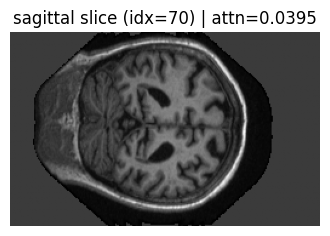

Top 2: view=sagittal, slice=82, attention=0.0380


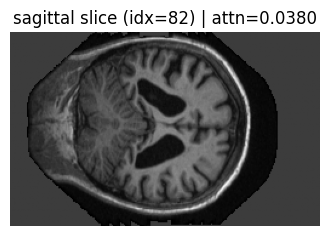

Top 3: view=sagittal, slice=63, attention=0.0367


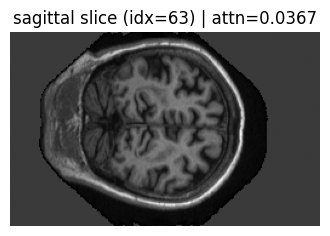

Top 4: view=coronal, slice=165, attention=0.0350


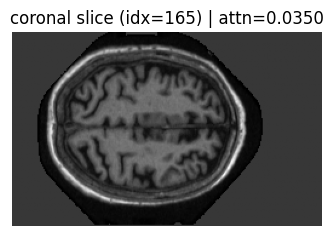

Top 5: view=sagittal, slice=89, attention=0.0300


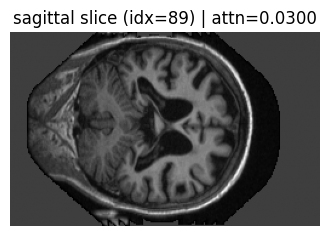

{'pred_label': 'AD',
 'prob_ad': 0.8687038421630859,
 'top_slices': [35, 37, 34, 28, 38],
 'top_alphas': [0.03949357941746712,
  0.03800054267048836,
  0.036661580204963684,
  0.035034265369176865,
  0.029986700043082237]}

In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SliceAttentionClassifier(emb_dim=256, num_classes=2)
model.load_state_dict(torch.load(f"{WORK_DIR}/baselineB_best_model.pth", map_location=device))
model.to(device)
model.eval()

patientId = patientId # id
patientId = "sub-OASIS10137" # id

query_patient(
    model=model,
    raw_dir=f"{DATA_ROOT}/raw/test",
    device=device,
    patient_id=patientId,
    top_k=numer_of_top_slices
)

# Check
# sub-OASIS10137 -> AD
# sub-OASIS10179 -> AD
# sub-OASIS10216 -> CN (non-AD)
# sub-OASIS10332 -> CN (non-AD)